# Transformers

### Resources
[Peter Bloem's Blog](http://www.peterbloem.nl/blog/transformers)

[Jay Alammar's Blog](https://jalammar.github.io/illustrated-transformer/)

[TensorFlow Blog](https://www.tensorflow.org/tutorials/text/transformer)

[Harvard NLP](http://nlp.seas.harvard.edu/2018/04/01/attention.html)

![transformer](https://i.imgur.com/FNMad1g.png)

## Self-Attention

Self-attention is a sequence-to-sequence operation: a sequence of vectors goes in, and a sequence of vectors comes out. 

Let's call the input vectors $x_1, x_2, \ldots x_t$ and the corresponding output vectors $y_1, y_2, \ldots y_t$. The vectors all have dimension k. Output vector $y_i$ is simply a weighted average of all the input vectors.

***Note:-*** Easier to understand if you assume a single sentence of length $t$ and each word a $k-dim$ vector

$$y_{i} = \sum_{{j}} w_{{i}{j}} x_{j}$$

$w_{{i}{j}}$ provides the relationsip between $x_{i}, x_{j}$

$$w'_{{i}{j}} = {x_{i}}^Tx_{j}$$ The simplest thing that could be done is take a dot product between the two vectors as a measure of similarity.

$$w_{{i}{j}} = \frac{\text{exp } w'_{{i}{j}}}{\sum_{j} \text{exp }w'_{{i}{j}}}$$

![basic-self-attention](http://www.peterbloem.nl/files/transformers/self-attention.svg)

In the example above to find the output vector $y_{2}$, we take a dot product between every vector $x_{i}$ and $x_{2}$, which gives us a weight vector $w_{2i}$. Multiply the weight vector $w_{2i}$ with corresponding input vector $x_{i}$ and sum them up to get the output vector $y_{2}$

```python
import numpy as np

# x1, x2, ..., x10 with each vector of dimension 5
# x --> (10, 5)
x = np.random.random(size=(10, 5))
# weights --> (10, 10)
weights = np.dot(x, x.T)

# weights[i, j] represent weight of xj for xi
for idx, w in enumerate(weights):
    weights[idx] = np.exp(w)/sum(np.exp(w))

# y1, y2, ..., y10 => output vector
# y --> (10, 5)
y = np.matmul(weights, x)
```

In [1]:
import numpy as np

# x1, x2, ..., x10 with each vector of dimension 5
# x --> (10, 5)
x = np.random.random(size=(10, 5))
# weights --> (10, 10)
weights = np.dot(x, x.T)

weights = np.exp(weights)/np.sum(np.exp(weights), axis=0)
# y1, y2, ..., y10 => output vector
# y --> (10, 5)
y = np.matmul(weights, x)

### Query, Key and Value
Every input vector $𝐱_{i}$ is used in three different ways in the self attention operation:

* It is compared to every other vector to establish the weights for its own output $𝐲_{i}$
* It is compared to every other vector to establish the weights for the output of the j-th vector $𝐲_{j}$
* It is used as part of the weighted sum to compute each output vector once the weights have been established

They are `query`, `key` and `value` respectively. We add three **$k×k$** weight matrices $𝐖_{q}$, $𝐖_{k}$, $𝐖_{v}$ and compute three linear transformations of each $x_{i}$, for the three different parts of the self attention
![img](https://i.imgur.com/OhTQX01.png)

**Shapes**
* $W_{q}, W_{k}, W_{v} - kxk$ matrix
* $q_{i}, k_{i}, v_{i} - k$ dimensional vector
* $w'_{{i}{j}}$ - scalar value
* $w_{{i}{j}}$ - scalar value
* $y_{i} - k$ dimensional vector

### Scaling Dot Product

As the number of dimensions **$k$** increases, the dot-product $w'_{{i}{j}}$ grows too. Softmax is sensitive to large values, as the value increases the curve tends to flatten & hence resulting in smaller gradients. This in turn slows down learning. Hence, we scale down the value $w'_{{i}{j}}$ by dividing it by $\sqrt{k}$. 

Why $\sqrt{k}$? Imagine a vector in $ℝ^{k}$ with values all c. Its Euclidean length is $k\sqrt{c}$.

```python
len1 = 256
x = np.array([10]*len1)
z1 = np.dot(x, x.T)
print(z1, z1/np.sqrt(len1)) # 25600 1600.0

len2 = 512
y = np.array([10]*len2)
z2 = np.dot(y, y.T)
print(z2, z2/np.sqrt(l2)) # 51200 2262.74
```
Even though the number of dimensions increased by a factor of $2$, the relative increase in value was low

### Implementation

```python
def SingleHeadAttention(query, key, value):
    """
    query - (batch_size, query_len, embedding_size)
    key - (batch_size, value_len, embedding_size)
    value - (batch_size, value_len, embedding_size)
    """
    
    # Step 1 - Matrix multiplication between query and key
    # weights --> (batch_size, query_len, value_len)
    weights = tf.matmul(query, key.T)

    # Step 2 - Weights Normalization
    # weights --> (batch_size, query_len, value_len)
    dim = key.shape[-1]
    weights = weights/np.sqrt(dim)
    
    # Step 3 - Softmax scores
    # weights --> (batch_size, query_len, value_len)
    weights = tf.nn.softmax(weights, axis=-1)
    
    # Step 4 - Context Vector
    # context --> (batch_size, query_len, embedding_size)
    context = tf.matmul(weights, value)
    
    return context
```

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
from pprint import pprint
import seaborn as sns
import tensorflow as tf
from utils import get_sequences

In [4]:
%matplotlib inline

In [5]:
style.use('seaborn-poster')

In [6]:
def SingleHeadAttention(query, key, value):
    """
    query - (batch_size, query_len, embedding_size)
    key - (batch_size, value_len, embedding_size)
    value - (batch_size, value_len, embedding_size)
    """
    
    # Step 1 - Matrix multiplication between query and key
    # weights --> (batch_size, query_len, value_len)
    weights = tf.matmul(query, key, transpose_b=True)

    # Step 2 - Weights Normalization
    # weights --> (batch_size, query_len, value_len)
    dim = key.shape[-1]
    weights = weights/np.sqrt(dim)
    
    # Step 3 - Softmax scores
    # weights --> (batch_size, query_len, value_len)
    weights = tf.nn.softmax(weights, axis=-1)
    
    # Step 4 - Context Vector
    # context --> (batch_size, query_len, embedding_size)
    context = tf.matmul(weights, value)
    
    return weights, context

In [7]:
with open("text", "r") as file:
    sentences = file.readlines()

In [8]:
for x in sentences:
    print(x)

Take whichever you want.

He is too short.

They have their own trouble.

You have four choices.

Can I make a telephone call please?

He's very talented.

His family is in Boston.

This might be interesting.

The ship crashed on the rocks.

I need a table for three people.

I like your article.

Tom gave me a ride home.

I always keep my word.

That isn't cheap.

Thanks for sharing that.

How many days are there in a week.



Below I've written a utility function *(get_sequences in utils.py)* that takes in a bunch of sentences & returns a 3D matrix of shape `(num_sentences, max_length, vocab_size)`.
* num_sentences - Number of sentences
* max_length - Length of the largest sentence
* vocab_size - Vocabulary size

Each word in a sequence is one-hot vector encoded

In [9]:
_, key = get_sequences(sentences, len(sentences))
_, value = get_sequences(sentences, len(sentences))                       
sentences, query = get_sequences(sentences, len(sentences))

# Sentences: 16
Vocabulary Size: 66
Max Length Sentence: 8
# Sentences: 16
Vocabulary Size: 66
Max Length Sentence: 8
# Sentences: 16
Vocabulary Size: 66
Max Length Sentence: 8


In [10]:
key.shape, value.shape, query.shape

((16, 8, 67), (16, 8, 67), (16, 8, 67))

In [11]:
weights, out = SingleHeadAttention(query, key, value)

In [12]:
weights.shape, out.shape 

(TensorShape([16, 8, 8]), TensorShape([16, 8, 67]))

In [13]:
h, w = 3, 3

In [14]:
def visualize_weights(weights):
    f = plt.figure(figsize=(12, 12))
    gs = f.add_gridspec(h, w)

    f.suptitle('Attention weights visualization', fontsize=20)

    for i in range(h):
        for j in range(w):
            ax = f.add_subplot(gs[i, j])
            g = sns.heatmap(weights[i*h+j], cbar=False, cmap="binary")
            words = sentences[i*h+j].split()
            temp = 8 - len(words)
            extras = ["_"]*temp
            words += extras
            plt.xticks(np.arange(8), words, rotation='vertical')
            plt.yticks(np.arange(8), words, rotation='horizontal')
            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])

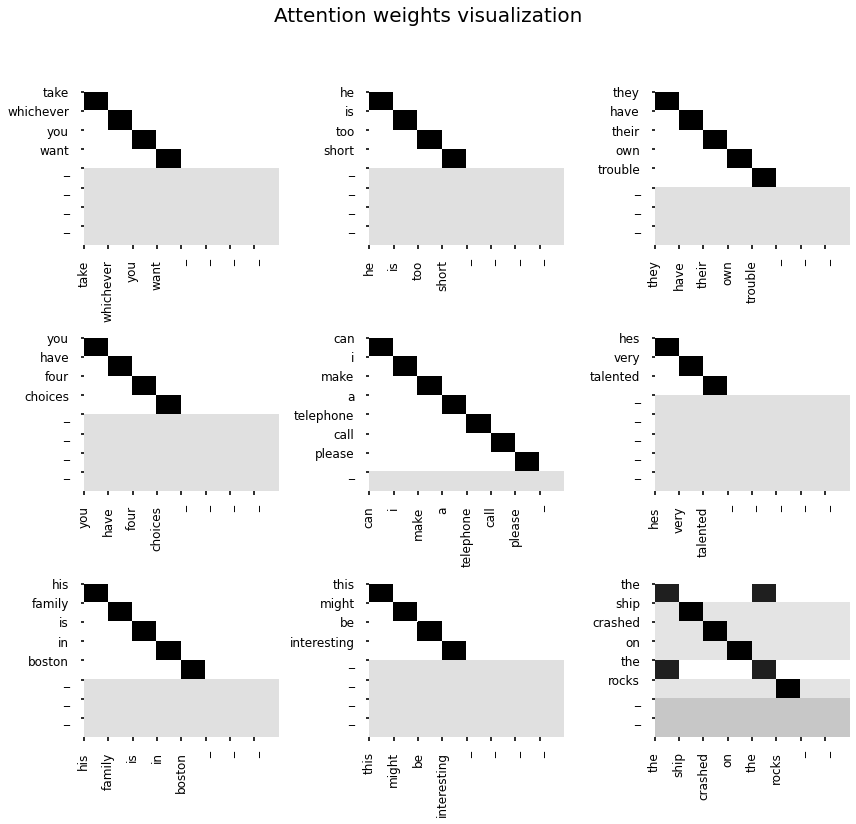

In [15]:
visualize_weights(weights)

**Since the dot product of one-hot encoded vectors will be maximum with itself, weights are maximum along the diagonals.**

## MultiHead Attention

Each word may have different meaning depending on the context. Mutlihead attention gives the attention layer multiple “representation subspaces”.

We can give the self attention greater power of discrimination, by combining several self attention mechanisms (which we'll index with r), each with different matrices $W_q^{r}, W_k^{r}, W_v^{r}$. These are called attention heads.

For input $x_{i}$ each attention head produces a different output vector $y_{i}^{r}$. We concatenate these, and pass them through a linear transformation to reduce the dimension back to k.

![mutlihead](https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

### Narrow and Wide Self-Attention
There are two ways to apply self-attention -
1. Cut the embedding vectors into chunk. Suppose, the embedding vector has *256* dimensions and we have *8* dimensions, we can cut it into *8* chunks each of size *32*. This means that the matrices $W_q^{r}, W_k^{r}, W_v^{r}$ are all *32x32*
2. Make each of the matrices of size *256x256* and apply each head to the whole vector of size *256*

The first option is faster & memory effecient whereas the latter one gives better performance.

### Implementation

1. We think of the $h$ attention heads as $h$ separate sets of three matrices $W_q^{r}, W_k^{r}, W_v^{r}$, but it's actually more efficient to combine these heads into three single $k×hk$ matrices, so that we can compute all the concatenated queries, keys and values in a single matrix multiplication.
2. The output of each linear module has size `(batch_size, seq_len, num_heads*embedding_size)`, which we simply reshape to `(batch_size, seq_len, num_heads, embedding_size)` give each head its own dimension.
3. Get context vector by applying `SingleHeadAttention` for each of the heads.
4. The attention output for each head is then concatenated and put through a final Dense layer.

```python
from tensorflow.keras.layers import Dense

def MultiHeadAttention(num_heads, d_model, query, key, value):
    '''
    Arguments
    ---------
    num_heads - int
        Specifies the number of heads in multihead attention network
        
    d_model - int
        Input dimension for the multihead net. A token is embedded as a vector of size `embedding_size`, which is  then linearly transformed into a vector of size `d_model`
          
    query - Query 3D matrix of shape (batch_size, query_len, embedding_size)
    
    key - Key 3D matrix of shape (batch_size, value_len, embedding_size)
   
    value - Value 3D matrix of shape (batch_size, value_len, embedding_size)   
    '''
    
    # Step 1 - Create 4 matrix Wq, Wk, Wv
    # creates a kernel of size [embedding_size, d_model]
    Wq = Dense(d_model)
    Wk = Dense(d_model)
    Wv = Dense(d_model)
    Wo = Dense(d_model)
    
    # Step 2 - Perform linear transformation
    # query --> (batch_size, query_len, d_model)
    query = Wq(query)
    # key --> (batch_size, value_len, d_model)
    key = Wk(key)
    # value --> (batch_size, value_len, d_model)
    value = Wv(value)
    
    # Step 3 - Reshape query,key and value. Transform 3D matrix to 4D matrix by breaking along the last axis & then transpose.
    assert d_model % num_heads == 0
    depth = d_model/num_heads
    
    # query --> (batch_size, query_len, num_heads, depth)
    query = np.reshape(query, (query.shape[0], query.shape[1], num_heads, depth))
    # query --> (batch_size, num_heads, query_len, depth)
    query = np.transpose(query, (0, 2, 1, 3))

    # key --> (batch_size, value_len, num_heads, depth)    
    key = np.reshape(key, (key.shape[0], key.shape[1], num_heads, depth))
    # key --> (batch_size, num_heads, query_len, depth)
    key = np.transpose(key, (0, 2, 1, 3))

    # value --> (batch_size, value_len, num_heads, depth)
    value = np.reshape(value, (value.shape[0], value.shape[1], depth))
    # value --> (batch_size, num_heads, query_len, depth)
    value = np.transpose(value, (0, 2, 1, 3))
    
    # Step 4 - Apply ScaledDotProduct (SingleHeadAttention) on each of the heads
    attention_weights, context_vector = SingleHeadAttention(query, key, value)
    # context_vector --> (batch_size, query_len, num_heads, depth)
    context_vector = np.transpose(scaled_vector, (0, 2, 1, 3))
    
    # Step 5 - Concatenate along the `num_heads` axis
    # context_vector --> (batch_size, query_len, d_model)    
    context_vector = np.reshape(context_vector, 
                                (context_vector.shape[0], context_vector.shape[1], d_model))
    
    # Step 6 - Apply linear transformation by multiplication with Wo
    context_vector = Wo(context_vector)
    return attention_weights, context_vector

```

In [16]:
from tensorflow.keras.layers import Dense

In [17]:
def MultiHeadAttention(num_heads, d_model, query, key, value):
    # Step 1 - Create 4 matrix Wq, Wk, Wv
    # creates a kernel of size [embedding_size, d_model]
    Wq = Dense(d_model)
    Wk = Dense(d_model)
    Wv = Dense(d_model)
    Wo = Dense(d_model)
    
    # Step 2 - Perform linear transformation
    # query --> (batch_size, query_len, d_model)
    query = Wq(query)
    # key --> (batch_size, value_len, d_model)
    key = Wk(key)
    # value --> (batch_size, value_len, d_model)
    value = Wv(value)
    
    # Step 3 - Reshape query,key and value. Transform 3D matrix to 4D matrix by breaking along the last axis & then transpose.
    assert d_model % num_heads == 0
    depth = d_model//num_heads
    
    # query --> (batch_size, query_len, num_heads, depth)
    query = np.reshape(query, (query.shape[0], query.shape[1], num_heads, depth))
    # query --> (batch_size, num_heads, query_len, depth)
    query = np.transpose(query, (0, 2, 1, 3))

    # key --> (batch_size, value_len, num_heads, depth)    
    key = np.reshape(key, (key.shape[0], key.shape[1], num_heads, depth))
    # key --> (batch_size, num_heads, query_len, depth)
    key = np.transpose(key, (0, 2, 1, 3))

    # value --> (batch_size, value_len, num_heads, depth)
    value = np.reshape(value, (value.shape[0], value.shape[1], num_heads, depth))
    # value --> (batch_size, num_heads, query_len, depth)
    value = np.transpose(value, (0, 2, 1, 3))
    
    # Step 4 - Apply ScaledDotProduct (SingleHeadAttention) on each of the heads
    attention_weights, context_vector = SingleHeadAttention(query, key, value)
    # context_vector --> (batch_size, query_len, num_heads, depth)
    context_vector = np.transpose(context_vector, (0, 2, 1, 3))
    
    # Step 5 - Concatenate along the `num_heads` axis
    # context_vector --> (batch_size, query_len, d_model)    
    context_vector = np.reshape(context_vector, 
                                (context_vector.shape[0], context_vector.shape[1], d_model))
    
    # Step 6 - Apply linear transformation by multiplication with Wo
    context_vector = Wo(context_vector)
    return attention_weights, context_vector

In [18]:
num_heads = 4
d_model = 512

In [19]:
weights, out = MultiHeadAttention(num_heads, d_model, query, key, value)

In [20]:
out.shape

TensorShape([16, 8, 512])

In [21]:
weights.shape

TensorShape([16, 4, 8, 8])

In [22]:
def visualize_weights_individual_head(index):
    h, w = 3, 3

    f = plt.figure(figsize=(12, 12))
    gs = f.add_gridspec(h, w)

    f.suptitle(f'Attention weights visualization (Head {index})', fontsize=20)

    for i in range(h):
        for j in range(w):
            ax = f.add_subplot(gs[i, j])
            g = sns.heatmap(weights[i*h+j][index], cbar=False, cmap="binary")
            words = sentences[i*h+j].split()
            temp = 8 - len(words)
            extras = ["_"]*temp
            words += extras
            plt.xticks(np.arange(8), words, rotation='vertical')
            plt.yticks(np.arange(8), words, rotation='horizontal')
            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
    f.tight_layout(rect=[0, 0.03, 1, 0.9])

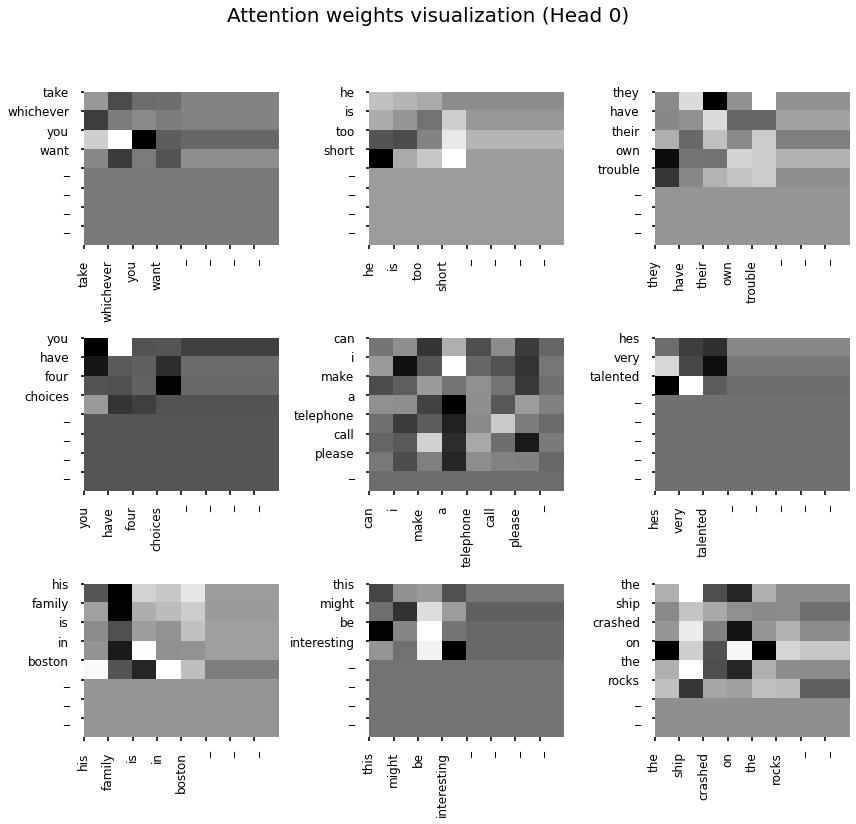

In [23]:
visualize_weights_individual_head(0)

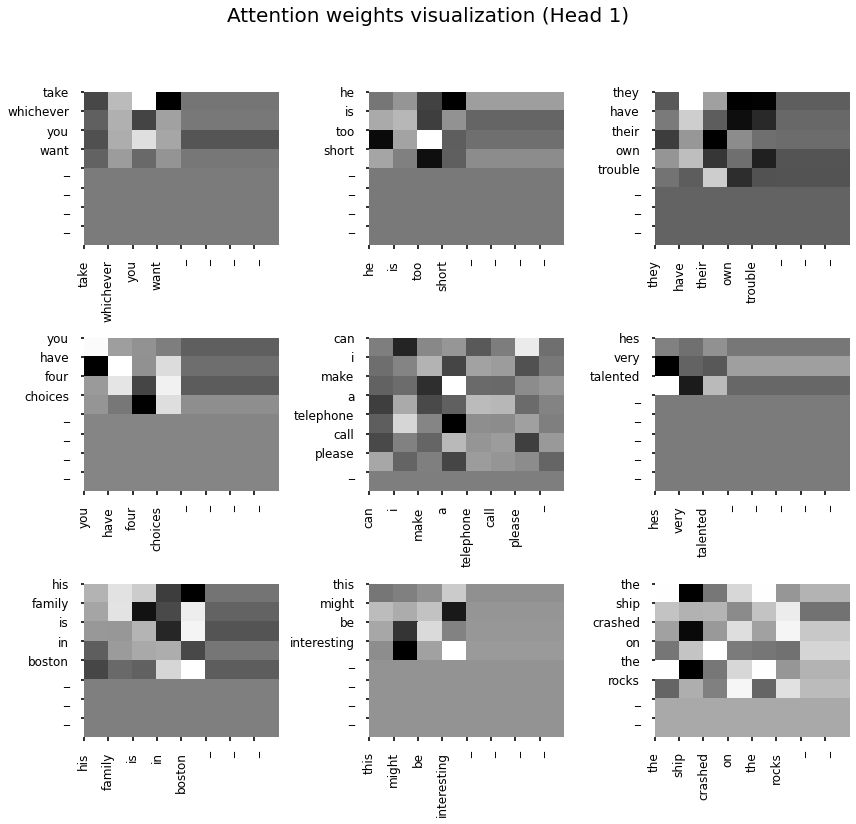

In [24]:
visualize_weights_individual_head(1)

**Notice that a word doesn't align maximum weight to itself. This is because we multiply the query, key and value vectors with weight matrices $W_q^{r}, W_k^{r}, W_v^{r}$ respectively.**

### Concatenating the Heads

Concatenating the attention weights obtained from each individual heads and visualizing it.

In [25]:
concatenated_weights = tf.reduce_sum(weights, axis=1)

In [26]:
concatenated_weights.shape

TensorShape([16, 8, 8])

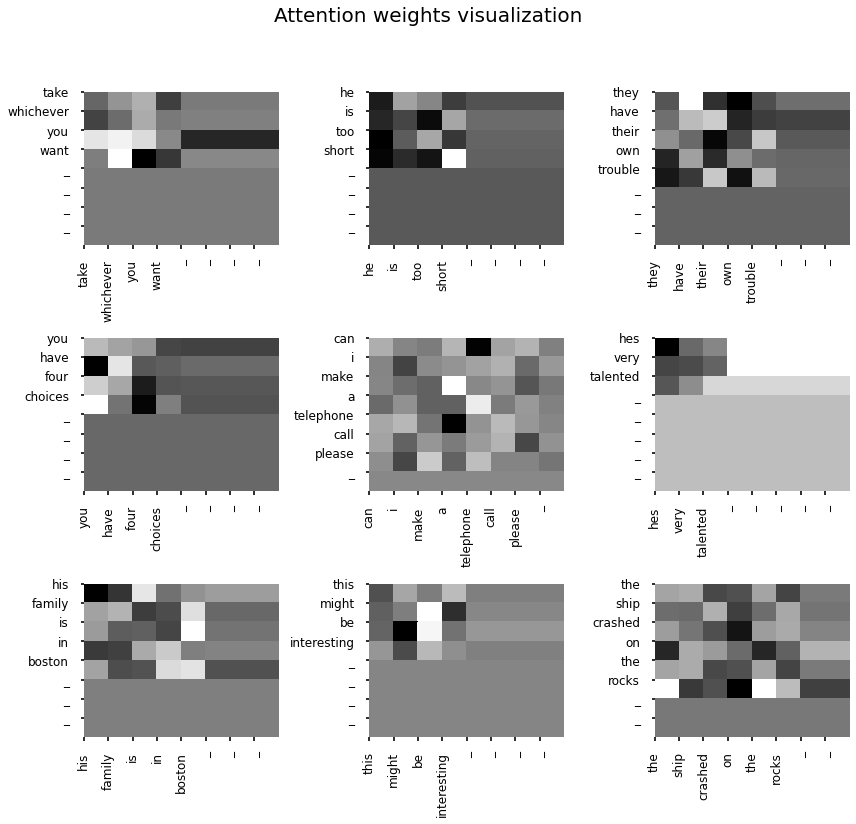

In [27]:
visualize_weights(concatenated_weights)

## Positional Encoding

Embeddings represent a token in a $k-dimensional$ space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence.

Since we have **no recurrent networks that can remember how sequences are fed into a model, we need to somehow give every word/part in our sequence a relative position** since a sequence depends on the order of its elements. These positions are added to the embedded representation of each word.

So after adding the positional encoding, **words will be closer to each other based on the similarity of their meaning and their position in the sentence**, in the $k-dimensional$ space.

![positional-encoding](https://i.imgur.com/Kc78rpW.png)

In [28]:
def positional_encoding(max_len, d_model):
    pos_enc = np.zeros((max_len, d_model))

    for pos in range(max_len):
        for i in range(0, d_model, 2):
            angle = pos / (np.power(10000, i/d_model))
            pos_enc[pos][i] = np.sin(angle)
            pos_enc[pos][i+1] = np.cos(angle)
    return pos_enc

In [29]:
pos_enc = positional_encoding(50, d_model)

In [30]:
pos_enc.shape

(50, 512)

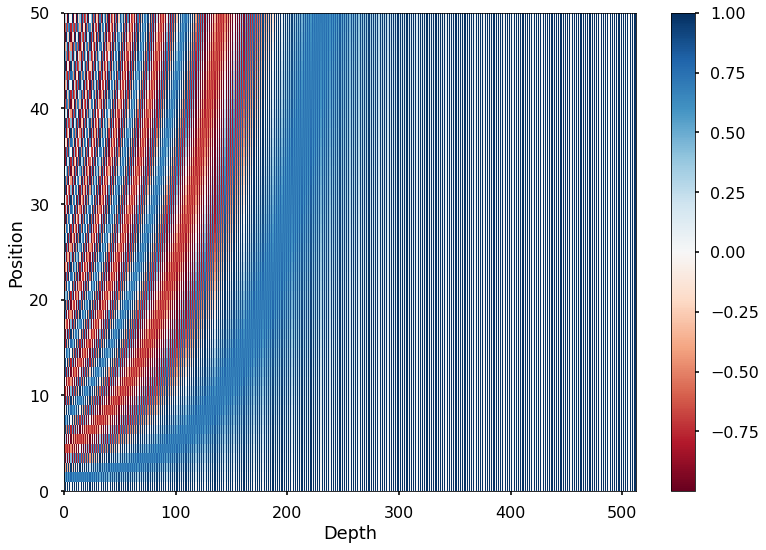

In [31]:
plt.pcolormesh(pos_enc, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Feed Forward Network

Each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

```python
def point_wise_feed_forward_network(d_model, dff, x):
    dense1 = Dense(dff, activation='relu')
    dense2 = Dense(d_model)
    
    out = dense1(x)
    out = dense2(out)
    return out
```

In [32]:
def point_wise_feed_forward_network(d_model, dff, x):
    dense1 = Dense(dff, activation='relu')
    dense2 = Dense(d_model)
    
    out = dense1(x)
    out = dense2(out)
    return out

In [33]:
ffn_out = point_wise_feed_forward_network(512, 1024, out)

In [34]:
out.shape, ffn_out.shape

(TensorShape([16, 8, 512]), TensorShape([16, 8, 512]))

## LayerNormalization

Normalization and residual connections are standard tricks used to help deep neural networks train faster and more accurately. The layer normalization is applied over the embedding dimension only.

For more information, refer to my [notebook](../machine-learning/LayerNormalization.ipynb)

In it's simplest form, ***LayerNormalization*** can be implemented as follows.
```python
def layer_norm(x):
    size = x.shape[-1]
    a = np.ones(size)
    b = np.zeros(size)
    
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    
    x_hat = (x-mean)/(std+1e-6)
    
    return a*x_hat+b
```

We can otherwise, use `tf.keras.layers.LayerNormalization`,

I am not sure, if it involves any learning parameter. But I have suspicions that similar to ***BatchNormalization***, it too involves learning the parameters $\gamma$ and $\beta$. This is so because the [keras implementation](https://github.com/tensorflow/tensorflow/blob/v2.1.0/tensorflow/python/keras/layers/normalization.py) of *LayerNormalization* calls `tf.nn.batch_normalization` on line **1083**. Contrarily, the official documentation doesn't say if `tf.nn.batch_normalization` call involves any learnable parameters. Hence, yet to confirm the theory.

In [35]:
def layer_norm(x):
    size = x.shape[-1]
    a = np.ones(size)
    b = np.zeros(size)
    
    mean = np.mean(x, axis=-1, keepdims=True)
    std = np.std(x, axis=-1, keepdims=True)
    
    x_hat = (x-mean)/(std+1e-6)
    
    return a*x_hat+b

In [36]:
normalized_out = layer_norm(out)

In [37]:
out.shape, normalized_out.shape

(TensorShape([16, 8, 512]), TensorShape([16, 8, 512]))

# Encoder

The encoder layer consists of-
1. MultiHead Attention
2. Normalization & Residual Connecttion
3. Point-wise feed forward networks

In [41]:
from tensorflow.keras.layers import Dropout, LayerNormalization, Dense

In [142]:
def encoder(num_heads, d_model, query, key, value):
    # Step 1 - MultiHeadAttention
    weights, context_vector = MultiHeadAttention(num_heads, d_model, query, key, value)
    
    # Dropout
    dropout1 = Dropout(0.1)
    context_vector = dropout1(context_vector)
    
    # Step 2 - Normalize (x+attention(x))
    layer_norm1 = LayerNormalization()
    context_vector = layer_norm1(query+context_vector)
    
    # Step 3 - Pointwise FeedForward Network
    ffn_out = point_wise_feed_forward_network(d_model, 1024, context_vector)
    
    # Dropout
    dropout2 = Dropout(0.1)
    ffn_out = dropout2(ffn_out)
    
    # Step 4 - Normalization again
    layer_norm2 = LayerNormalization()
    encoder_out = layer_norm1(context_vector+ffn_out)
    
    return encoder_out

In [145]:
x = tf.random.uniform((64, 48, 512))

In [148]:
num_heads = 8
d_model = 512

In [149]:
encoder_out = encoder(num_heads, d_model, x, x, x)

In [150]:
encoder_out.shape

TensorShape([64, 48, 512])

**Repeating it multiple times**

In [151]:
for i in range(6):
    encoder_out = encoder(num_heads, d_model, encoder_out, encoder_out, encoder_out)

In [152]:
encoder_out.shape

TensorShape([64, 48, 512])